[View in Colaboratory](https://colab.research.google.com/github/huyhoang17/Colab_Temporary/blob/master/Training_CTC_Japanese_Recognition_10epochs.ipynb)

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:

!ls drive/My\ Drive/Japanese_Recognition/datasets

anpr_ocr      model			  wordlist_bi_clean.txt
anpr_ocr.zip  pp_vn_handwriting_data	  wordlist_mono_clean.txt
ETL1	      pp_vn_handwriting_data.zip
IAM_dataset   transcription.pk


In [0]:
# import os
import pickle
# TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
# print(TPU_WORKER)

In [0]:
# !rm -rf drive/My\ Drive/Japanese_Recognition/datasets/pp_vn_handwriting_data

In [0]:
# !unzip drive/My\ Drive/Japanese_Recognition/datasets/pp_vn_handwriting_data.zip -d drive/My\ Drive/Japanese_Recognition/datasets

In [0]:
# import zipfile
# zip_ref = zipfile.ZipFile('drive/My Drive/Japanese_Recognition/datasets/pp_vn_handwriting_data.zip', 'r')
# zip_ref.extractall('drive/My Drive/Japanese_Recognition/datasets')
# zip_ref.close()

In [7]:
!ls drive/My\ Drive/Japanese_Recognition/datasets/pp_vn_handwriting_data | wc -l 

7296


In [0]:
# import pickle
# with open('drive/My Drive/Japanese_Recognition/datasets/transcription.pk', 'rb') as f:  # noqa
#     data = pickle.load(f)
# no_samples = len(data)
# print(no_samples)

In [0]:
pp_dataset = 'drive/My Drive/Japanese_Recognition/datasets/pp_vn_handwriting_data'
img_size = (1150, 32)

In [10]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
import numpy as np
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
import cv2

Using TensorFlow backend.


TensorFlow version: 1.11.0-rc2
Keras version: 2.1.6


In [0]:
chars = '\ !%"#&\'()*+,-./0123456789:;?AÁẢÀÃẠÂẤẨẦẪẬĂẮẲẰẴẶBCDĐEÉẺÈẼẸÊẾỂỀỄỆFGHIÍỈÌĨỊJKLMNOÓỎÒÕỌÔỐỔỒỖỘƠỚỞỜỠỢPQRSTUÚỦÙŨỤƯỨỬỪỮỰVWXYÝỶỲỸỴZaáảàãạâấẩầẫậăắẳằẵặbcdđeéẻèẽẹêếểềễệfghiíỉìĩịjklmnoóỏòõọôốổồỗộơớởờỡợpqrstuúủùũụưứửừữựvwxyýỷỳỹỵz'

In [12]:
len(chars)

215

In [13]:
chars_ = []
for char in chars:
  chars_.append(char)
print(chars_)

['\\', ' ', '!', '%', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'Á', 'Ả', 'À', 'Ã', 'Ạ', 'Â', 'Ấ', 'Ẩ', 'Ầ', 'Ẫ', 'Ậ', 'Ă', 'Ắ', 'Ẳ', 'Ằ', 'Ẵ', 'Ặ', 'B', 'C', 'D', 'Đ', 'E', 'É', 'Ẻ', 'È', 'Ẽ', 'Ẹ', 'Ê', 'Ế', 'Ể', 'Ề', 'Ễ', 'Ệ', 'F', 'G', 'H', 'I', 'Í', 'Ỉ', 'Ì', 'Ĩ', 'Ị', 'J', 'K', 'L', 'M', 'N', 'O', 'Ó', 'Ỏ', 'Ò', 'Õ', 'Ọ', 'Ô', 'Ố', 'Ổ', 'Ồ', 'Ỗ', 'Ộ', 'Ơ', 'Ớ', 'Ở', 'Ờ', 'Ỡ', 'Ợ', 'P', 'Q', 'R', 'S', 'T', 'U', 'Ú', 'Ủ', 'Ù', 'Ũ', 'Ụ', 'Ư', 'Ứ', 'Ử', 'Ừ', 'Ữ', 'Ự', 'V', 'W', 'X', 'Y', 'Ý', 'Ỷ', 'Ỳ', 'Ỹ', 'Ỵ', 'Z', 'a', 'á', 'ả', 'à', 'ã', 'ạ', 'â', 'ấ', 'ẩ', 'ầ', 'ẫ', 'ậ', 'ă', 'ắ', 'ẳ', 'ằ', 'ẵ', 'ặ', 'b', 'c', 'd', 'đ', 'e', 'é', 'ẻ', 'è', 'ẽ', 'ẹ', 'ê', 'ế', 'ể', 'ề', 'ễ', 'ệ', 'f', 'g', 'h', 'i', 'í', 'ỉ', 'ì', 'ĩ', 'ị', 'j', 'k', 'l', 'm', 'n', 'o', 'ó', 'ỏ', 'ò', 'õ', 'ọ', 'ô', 'ố', 'ổ', 'ồ', 'ỗ', 'ộ', 'ơ', 'ớ', 'ở', 'ờ', 'ỡ', 'ợ', 'p', 'q', 'r', 's', 't', 'u', 'ú', 'ủ', 'ù', 'ũ', 'ụ', 'ư'

In [14]:
len(chars_)

215

In [0]:
import logging
def get_logger(name):
    logger = logging.getLogger(name)
    logger.setLevel(logging.DEBUG)

    # formatter
    fmt = logging.Formatter(
        '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )

    # handler
    handler = logging.StreamHandler()
    handler.setLevel(logging.DEBUG)
#     file_handler = logging.FileHandler(cf.LOGGING, mode='a')
#     file_handler.setLevel(logging.DEBUG)
    handler.setFormatter(fmt)
#     file_handler.setFormatter(fmt)

    # add handler to formatter
    logger.addHandler(handler)
#     logger.addHandler(file_handler)

    return logger
logger = get_logger(__name__)

In [0]:
def labels_to_text(letters, labels):
    return ''.join(list(map(lambda x: letters[x] if x < len(letters) else "", labels)))  # noqa


def text_to_labels(letters, text):
    return list(map(lambda x: letters.index(x), text))


def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = labels_to_text(out_best)
        ret.append(outstr)
    return ret


def decode_predict_ctc(out, chars, top_paths=1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        lables = K.get_value(
            K.ctc_decode(
                out, input_length=np.ones(out.shape[0]) * out.shape[1],
                greedy=False, beam_width=beam_width, top_paths=top_paths
            )[0][i]
        )[0]
        text = labels_to_text(chars, lables)
        results.append(text)
    return results


def predit_a_image(model_p, pimg, top_paths=1):
    # c = np.expand_dims(a.T, axis=0)
    net_out_value = model_p.predict(pimg)
    top_pred_texts = decode_predict_ctc(net_out_value, top_paths)
    return top_pred_texts


def is_valid_str(letters, s):
    for ch in s:
        if ch not in letters:
            return False
    return True

In [0]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [0]:
def CRNN_model():
    act = 'relu'
    input_data = Input(name='the_input', shape=img_size + (1, ), dtype='float32')
    inner = Conv2D(16, (3, 3), padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(
        inner)
    inner = Conv2D(32, (3, 3), padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(
        inner)
    inner = Conv2D(64, (3, 3), padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv3')(input_data)
    inner = MaxPooling2D(pool_size=(2, 2), name='max3')(
        inner)
    inner = Conv2D(128, (3, 3), padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv4')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max4')(
        inner)
    inner = Conv2D(256, (3, 3), padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv5')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max5')(
        inner)

#     conv_to_rnn_dims = (1150 // (2 ** 2),
#                         (32 // (2 ** 2)) * 16)
    conv_to_rnn_dims = (256, 572)
    print(conv_to_rnn_dims)
#     import pdb; pdb.set_trace()
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)
  
    # cuts down input size going into RNN:
    # TIME_DENSE_SIZE = 256
    inner = Dense(256, activation=act, name='dense1')(inner)

    gru_1 = GRU(256, return_sequences=True,
                kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(256, return_sequences=True, go_backwards=True,
                 kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(256, return_sequences=True,
                kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(256, return_sequences=True, go_backwards=True,
                 kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    # no unique labels
    inner = Dense(216, kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)

    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[256], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    # loss function
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [y_pred, labels, input_length, label_length]
    )

    model = Model(inputs=[input_data, labels,
                          input_length, label_length], outputs=loss_out)

    y_func = K.function([input_data], [y_pred])

    return model, y_func

In [0]:
class TextSequenceGenerator(keras.utils.Sequence):
    """Generates data for Keras"""

    def __init__(self, samples, batch_size=16,
                 img_size=img_size, max_text_len=160,
                 downsample_factor=4, shuffle=True):
        # train 95, test 5
        imgs, gt_texts = [], []
        for sample in samples:
            img = list(sample.keys())[0]
            fn_path = os.path.join(pp_dataset, img.split('/')[-1])
            imgs.append(fn_path)
            gt_texts.append(list(sample.values())[0])
        self.imgs = imgs
        self.gt_texts = gt_texts

        self.max_text_len = max_text_len
        self.chars = chars
        self.blank_label = len(self.chars)
        self.ids = range(len(self.imgs))

        self.img_size = img_size
        self.img_w, self.img_h = self.img_size
        self.batch_size = batch_size
        self.downsample_factor = downsample_factor
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.ids) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        indexes = self.indexes[index *
                               self.batch_size:(index + 1) * self.batch_size]

        ids = [self.ids[k] for k in indexes]

        for id_ in [1820, 5915]:
            if id_ in ids:
                ids.remove(id_)
        X, y = self.__data_generation(ids)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, ids):
        """Generates data containing batch_size samples"""
#         for i, id_ in enumerate(ids):
#             img = cv2.imread(self.imgs[id_], cv2.IMREAD_GRAYSCALE)
#             if img is None:
#                 ids.remove(id_)
#                 print("\n==> Error id: ", id_)
        size = len(ids)
        
        if K.image_data_format() == 'channels_first':
            X = np.ones([size, 1, self.img_w, self.img_h])
        else:
            X = np.ones([size, self.img_w, self.img_h, 1])
        Y = np.ones([size, self.max_text_len])
#         input_length = np.ones((size, 1), dtype=np.float32) * \
#             (self.img_w // self.downsample_factor - 2)
        input_length = np.ones((size, 1), dtype=np.float32) * 254
        label_length = np.zeros((size, 1), dtype=np.float32)

        # Generate data
        for i, id_ in enumerate(ids):
            
            img = cv2.imread(self.imgs[id_], cv2.IMREAD_GRAYSCALE)  # (h, w)
            if img is None:
                continue
#             img = 255 - img  # bg: black, text: white
            # bg: white, text: black
            ratio = img.shape[0] / self.img_h
            new_w = int(img.shape[1] / ratio) + 1
            resized_image = cv2.resize(img, (new_w, self.img_h))  # (h, w)
            img = cv2.copyMakeBorder(
                resized_image, 0, 0, 0, self.img_w - resized_image.shape[1],
                cv2.BORDER_CONSTANT, value=0
            )  # (h, w)
            img = img / 255  # (h, w)

            if K.image_data_format() == 'channels_first':
                img = np.expand_dims(img, 0)  # (1, h, w)
                img = np.expand_dims((0, 2, 1))  # (1, w, h)
            else:
                img = np.expand_dims(img, -1)  # (h, w, 1)
                img = img.transpose((1, 0, 2))  # (w, h, 1)

            X[i] = img
            text2label = text_to_labels(self.chars, self.gt_texts[id_])
            Y[i] = text2label + \
                [self.blank_label for _ in range(
                    self.max_text_len - len(text2label))]
            label_length[i] = len(self.gt_texts[id_])

        inputs = {
            'the_input': X,
            'the_labels': Y,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([size])}

        return (inputs, outputs)

In [0]:
def train(pretrained=False):

    with open('drive/My Drive/Japanese_Recognition/datasets/transcription.pk', 'rb') as f:  # noqa
        data = pickle.load(f)
    no_samples = len(data)
    no_train_set = int(no_samples * 0.95)
    no_val_set = no_samples - no_train_set
    logger.info("No train set: %d", no_train_set)
    logger.info("No val set: %d", no_val_set)

    train_set = TextSequenceGenerator(
        data[:no_train_set],
        img_size=img_size, max_text_len=256,
        downsample_factor=4,
        shuffle=True
    )
#     import pdb; pdb.set_trace()
    test_set = TextSequenceGenerator(
        data[no_train_set:],
        img_size=img_size, max_text_len=256,
        downsample_factor=4,
        shuffle=False
    )

    model, y_func = CRNN_model()

    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)

    ckp = ModelCheckpoint(
        "drive/My Drive/Japanese_Recognition/models/model_cp_CTC_jps.hdf5", monitor='val_loss',
        verbose=1, save_best_only=True, save_weights_only=True
    )
    earlystop = EarlyStopping(
        monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
    )

#     model = tf.contrib.tpu.keras_to_tpu_model(
#     model,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
    
    model.fit_generator(generator=train_set,
                        steps_per_epoch=no_train_set // 16,
                        epochs=10,
                        validation_data=test_set,
                        validation_steps=no_val_set // 16,
                        callbacks=[ckp, earlystop])

    return model, y_func

In [21]:
model, y_func = train()

model_json = model.to_json()
with open('drive/My Drive/Japanese_Recognition/models/config_jps.json', 'w') as f:
    f.write(model_json)

model.save_weights('drive/My Drive/Japanese_Recognition/models/best_model_CTC_jps.h5')

2018-09-30 11:24:55,464 - __main__ - INFO - No train set: 6931
2018-09-30 11:24:55,466 - __main__ - INFO - No val set: 365


(256, 572)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 1150, 32, 1)  0                                            
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 1150, 32, 64) 640         the_input[0][0]                  
__________________________________________________________________________________________________
max3 (MaxPooling2D)             (None, 575, 16, 64)  0           conv3[0][0]                      
__________________________________________________________________________________________________
conv4 (Conv2D)                  (None, 575, 16, 128) 73856       max3[0][0]                       
__________________________________________________________________________________________________

In [0]:
from keras.models import model_from_json

with open('drive/My Drive/Japanese_Recognition/models/config_jps.json') as f:
    json_string = f.read()

model = model_from_json(json_string)
model.load_weights('drive/My Drive/Japanese_Recognition/models/best_model_CTC_jps.h5')

In [0]:
input_data = model.get_layer('the_input').output
y_pred = model.get_layer('softmax').output
model_p = Model(inputs=input_data, outputs=y_pred)

In [23]:
with open('drive/My Drive/Japanese_Recognition/datasets/transcription.pk', 'rb') as f:  # noqa
    data = pickle.load(f)
no_samples = len(data)
no_train_set = int(no_samples * 0.95)
no_val_set = no_samples - no_train_set
test_set = TextSequenceGenerator(
    data[no_train_set:],
    img_size=img_size, max_text_len=256,
    downsample_factor=4,
    shuffle=False
)
texts = []
for sample in data:
  texts.append(list(sample.values())[0])
print(max(map(len, texts)))

158


In [0]:
# import scipy.misc
# scipy.misc.imsave('outfile.jpg', image_array)
def predict(index_batch, index_img):
  samples = test_set[index_batch]
  img = samples[0]['the_input'][index_img]
  # plt.imshow(np.squeeze(img).T)
  img = np.expand_dims(img, axis=0)
  print(img.shape)
  
  net_out_value = model_p.predict(img)
  print(net_out_value.shape)
  pred_texts = top_pred_texts = decode_predict_ctc(net_out_value, chars_)
  print(pred_texts)
  gt_texts = test_set[index_batch][0]['the_labels'][index_img]
  gt_texts = labels_to_text(chars_, gt_texts.astype(int))
  print(gt_texts)

(1, 1150, 32, 1)
(1, 256, 216)
[' têm cạnh vệc nị sế Nở chược bạo âu biện và nưa bàn ciển']
Bên cạnh việc các nghệ sĩ NVƠNN được tạo điều kiện về nước biểu diễn
(1, 1150, 32, 1)
(1, 256, 216)
[' phờng quyên, nhông tan cang thnh ếi riệc mỗi củn nghệ hại sẽ']
thường xuyên, chúng tôi cũng tính tới cả việc mời các nghệ sĩ hoặc các
(1, 1150, 32, 1)
(1, 256, 216)
[' tện đang Vên gả kợn han kha gha các cột tha quác tó dú mào dó']
vận động viên gốc Việt tham gia các cuộc thi quốc tế dưới màu cờ
(1, 1150, 32, 1)
(1, 256, 216)
[' canh N), kh la gày tạ vên hn tói. Thón gả phýp cấc y']
của VN, có thể là ngay tại Sea Games tới. Nhóm giải pháp cuối cùng
(1, 1150, 32, 1)
(1, 256, 216)
[' chú huạng tó có vốo đề như trạn i ông dhạn lông bạn. a on tó']
chú trọng tới các vấn đề nhân đạo và xây dựng lòng tin. Bà con sẽ
(1, 1150, 32, 1)
(1, 256, 216)
[' tượch tụ tiều hiện bến ta đã về thển qua, k àng trên']
được tạo điều kiện tối đa để về thăm quê, thờ cúng tổ tiên.
(1, 1150, 32, 1)
(1, 256, 216)
[' C ui r

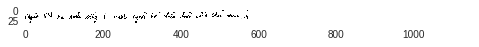

In [30]:
for i in range(16):
    predict(1, i)

In [0]:
img = test_set[0][0]['the_input'][0]

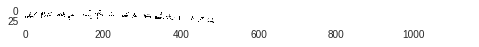

In [117]:
plt.imshow(np.squeeze(img).T)

In [0]:
import scipy.misc
scipy.misc.imsave('drive/My Drive/Japanese_Recognition/images/test_image.png', np.squeeze(img).T)

In [119]:
np.squeeze(img)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])